# UK Leasehold Counts by District

This notebook connects to the local MongoDB instance containing leasehold data and performs geospatial analysis to count the number of leaseholds within each UK district.

## Overview

- **Data Source**: MongoDB collection (`leases.leases`) containing ~7 million lease documents
- **Location Data**: Most documents have a `location` field containing GeoJSON Point objects (WGS84)
- **Geospatial Reference**: UK districts GeoJSON (`data/districts.geojson`) in EPSG:27700 (British National Grid)
- **Output**: DataFrame with leasehold counts per district

## Prerequisites

1. MongoDB running locally on `mongodb://localhost:27017`
2. `.env` file in the project root with connection details
3. Districts GeoJSON file at `data/districts.geojson`

---
## 1. Setup and Imports

First, we import all necessary libraries and configure our environment.

In [17]:
# Standard library imports
import os
import json
from pathlib import Path
from collections import defaultdict

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from dotenv import load_dotenv
from tqdm.notebook import tqdm

# For coordinate transformation (BNG to WGS84)
from pyproj import Transformer

# For geometric operations
from shapely.geometry import shape, Point
from shapely.prepared import prep
from shapely.strtree import STRtree

print("✓ All imports completed successfully!")

✓ All imports completed successfully!


---
## 2. Configuration

Load connection details from the `.env` file and set up paths.

In [18]:
# Load environment variables from .env file
env_path = Path("../.env")
load_dotenv(env_path)

# MongoDB Configuration - load from env or use defaults
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017")
MONGO_DATABASE = os.getenv("MONGO_DATABASE", "leases")
MONGO_COLLECTION = os.getenv("MONGO_COLLECTION", "leases")

# File paths
DATA_DIR = Path("data")
DISTRICTS_GEOJSON_PATH = DATA_DIR / "districts.geojson"

# Processing configuration
BATCH_SIZE = 50000  # Number of documents to process at a time

print(f"MongoDB URI: {MONGO_URI}")
print(f"Database: {MONGO_DATABASE}")
print(f"Collection: {MONGO_COLLECTION}")
print(f"Districts GeoJSON: {DISTRICTS_GEOJSON_PATH}")
print(f"Batch size: {BATCH_SIZE:,}")

MongoDB URI: mongodb://localhost:27017
Database: leases
Collection: leases
Districts GeoJSON: data/districts.geojson
Batch size: 50,000


---
## 3. Connect to MongoDB

Establish a connection to the local MongoDB instance and verify the collection exists.

In [19]:
# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[MONGO_DATABASE]
collection = db[MONGO_COLLECTION]

# Verify connection and get collection stats
total_documents = collection.estimated_document_count()
print(f"✓ Connected to MongoDB successfully!")
print(f"Total documents in collection: {total_documents:,}")

# Count documents with location field
docs_with_location = collection.count_documents({"location": {"$exists": True}})
print(f"Documents with location field: {docs_with_location:,}")
print(f"Percentage with location: {docs_with_location/total_documents*100:.1f}%")

✓ Connected to MongoDB successfully!
Total documents in collection: 6,711,969
Documents with location field: 6,415,947
Percentage with location: 95.6%


---
## 4. Load Districts GeoJSON

Load the UK districts boundaries from the GeoJSON file. The districts are in British National Grid (EPSG:27700), so we'll need to transform the coordinates.

In [20]:
# Load the districts GeoJSON
print(f"Loading districts from: {DISTRICTS_GEOJSON_PATH}")

with open(DISTRICTS_GEOJSON_PATH, 'r') as f:
    districts_geojson = json.load(f)

# Check the CRS (Coordinate Reference System)
crs = districts_geojson.get('crs', {})
print(f"GeoJSON CRS: {crs}")

# Count districts
num_districts = len(districts_geojson['features'])
print(f"\nTotal number of districts: {num_districts}")

# Preview some district names
print("\nSample districts:")
for feature in districts_geojson['features'][:5]:
    props = feature['properties']
    print(f"  - {props.get('LAD24NM', 'Unknown')} ({props.get('LAD24CD', 'N/A')})")

Loading districts from: data/districts.geojson
GeoJSON CRS: {'type': 'name', 'properties': {'name': 'EPSG:27700'}}

Total number of districts: 361

Sample districts:
  - Hartlepool (E06000001)
  - Middlesbrough (E06000002)
  - Redcar and Cleveland (E06000003)
  - Stockton-on-Tees (E06000004)
  - Darlington (E06000005)


---
## 5. Transform District Coordinates

The districts are in British National Grid (EPSG:27700), but our lease location data is likely in WGS84 (EPSG:4326). We need to transform the district boundaries to WGS84 for proper spatial matching.

In [21]:
def transform_coordinates_bng_to_wgs84(geometry, transformer):
    """
    Transform geometry coordinates from BNG (EPSG:27700) to WGS84 (EPSG:4326).
    Handles Polygon and MultiPolygon geometries.
    """
    geom_type = geometry['type']
    
    if geom_type == 'Polygon':
        new_coords = []
        for ring in geometry['coordinates']:
            new_ring = []
            for coord in ring:
                lon, lat = transformer.transform(coord[0], coord[1])
                new_ring.append([lon, lat])
            new_coords.append(new_ring)
        return {'type': 'Polygon', 'coordinates': new_coords}
    
    elif geom_type == 'MultiPolygon':
        new_polygons = []
        for polygon in geometry['coordinates']:
            new_rings = []
            for ring in polygon:
                new_ring = []
                for coord in ring:
                    lon, lat = transformer.transform(coord[0], coord[1])
                    new_ring.append([lon, lat])
                new_rings.append(new_ring)
            new_polygons.append(new_rings)
        return {'type': 'MultiPolygon', 'coordinates': new_polygons}
    
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")


# Create transformer from BNG to WGS84
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326", always_xy=True)

# Transform all district geometries
print("Transforming district coordinates from BNG to WGS84...")

districts = []
for feature in tqdm(districts_geojson['features'], desc="Transforming districts"):
    props = feature['properties']
    
    # Transform geometry
    transformed_geom = transform_coordinates_bng_to_wgs84(feature['geometry'], transformer)
    
    # Create shapely geometry and prepare it for faster queries
    geom = shape(transformed_geom)
    
    districts.append({
        'code': props.get('LAD24CD', 'Unknown'),
        'name': props.get('LAD24NM', 'Unknown'),
        'geometry': geom,
        'prepared': prep(geom)  # Prepared geometry for faster intersection tests
    })

print(f"\n✓ Transformed {len(districts)} districts to WGS84")

Transforming district coordinates from BNG to WGS84...


Transforming districts:   0%|          | 0/361 [00:00<?, ?it/s]


✓ Transformed 361 districts to WGS84


---
## 6. Build Spatial Index

Create a spatial index (R-tree) for efficient point-in-polygon queries. This dramatically speeds up the matching process for 7 million documents.

In [22]:
# Build spatial index using STRtree
print("Building spatial index...")

geometries = [d['geometry'] for d in districts]
spatial_index = STRtree(geometries)

# Create a mapping from geometry id to district index
geom_to_district = {id(geom): i for i, geom in enumerate(geometries)}

print(f"✓ Spatial index built with {len(geometries)} district polygons")

Building spatial index...
✓ Spatial index built with 361 district polygons


---
## 7. Sample Document Inspection

Let's examine a few documents to understand the structure of the location field.

In [23]:
# Get a sample document with location
sample_doc = collection.find_one({"location": {"$exists": True}})

if sample_doc:
    print("Sample document location field:")
    print(json.dumps(sample_doc.get('location'), indent=2))
    
    # Check location structure
    location = sample_doc.get('location')
    if isinstance(location, dict):
        loc_type = location.get('type')
        coords = location.get('coordinates')
        print(f"\nLocation type: {loc_type}")
        print(f"Coordinates: {coords}")
        if coords:
            print(f"Longitude: {coords[0]}, Latitude: {coords[1]}")
else:
    print("No documents with location field found!")

Sample document location field:
{
  "type": "Point",
  "coordinates": [
    -0.0294264,
    51.5153806
  ]
}

Location type: Point
Coordinates: [-0.0294264, 51.5153806]
Longitude: -0.0294264, Latitude: 51.5153806


---
## 8. Count Leaseholds per District

Process all documents with location data and count how many fall within each district. We use batch processing and a spatial index for efficiency.

In [24]:
def find_district(point, spatial_index, districts, geom_to_district):
    """
    Find which district a point belongs to using spatial index.
    Returns district code and name, or None if not found.
    """
    # Query spatial index for candidate districts
    candidate_indices = spatial_index.query(point)
    
    for idx in candidate_indices:
        district = districts[idx]
        # Use prepared geometry for faster containment check
        if district['prepared'].contains(point):
            return district['code'], district['name']
    
    return None, None

In [25]:
# Initialize counters
district_counts = defaultdict(int)
district_names = {}  # Store district names for output
no_location_count = 0
no_district_found = 0
processed_count = 0
error_count = 0

# Query only documents with location field
query = {"location": {"$exists": True, "$ne": None}}
projection = {"location": 1, "_id": 0}

print(f"Processing {docs_with_location:,} documents with location data...")
print(f"Using batch size: {BATCH_SIZE:,}")
print()

# Process documents in batches
cursor = collection.find(query, projection).batch_size(BATCH_SIZE)

with tqdm(total=docs_with_location, desc="Processing leaseholds") as pbar:
    for doc in cursor:
        processed_count += 1
        
        try:
            location = doc.get('location')
            
            if location and isinstance(location, dict):
                coords = location.get('coordinates')
                
                if coords and len(coords) >= 2:
                    # Create point (longitude, latitude)
                    point = Point(coords[0], coords[1])
                    
                    # Find district
                    district_code, district_name = find_district(
                        point, spatial_index, districts, geom_to_district
                    )
                    
                    if district_code:
                        district_counts[district_code] += 1
                        district_names[district_code] = district_name
                    else:
                        no_district_found += 1
                else:
                    no_location_count += 1
            else:
                no_location_count += 1
                
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # Only print first 5 errors
                print(f"Error processing document: {e}")
        
        pbar.update(1)

print(f"\n✓ Processing complete!")
print(f"  Total processed: {processed_count:,}")
print(f"  Assigned to district: {sum(district_counts.values()):,}")
print(f"  No location/invalid: {no_location_count:,}")
print(f"  Outside districts: {no_district_found:,}")
print(f"  Errors: {error_count:,}")

Processing 6,415,947 documents with location data...
Using batch size: 50,000



Processing leaseholds:   0%|          | 0/6415947 [00:00<?, ?it/s]


✓ Processing complete!
  Total processed: 6,415,947
  Assigned to district: 6,374,974
  No location/invalid: 0
  Outside districts: 40,973
  Errors: 0


---
## 9. Create Results DataFrame

Convert the results to a pandas DataFrame for analysis and visualization.

In [26]:
# Create DataFrame from results
results_data = []

for district_code, count in district_counts.items():
    results_data.append({
        'district_code': district_code,
        'district_name': district_names.get(district_code, 'Unknown'),
        'leasehold_count': count
    })

# Create DataFrame and sort by count
df_results = pd.DataFrame(results_data)
df_results = df_results.sort_values('leasehold_count', ascending=False).reset_index(drop=True)

# Add ranking
df_results['rank'] = df_results.index + 1
df_results = df_results[['rank', 'district_code', 'district_name', 'leasehold_count']]

print(f"Results DataFrame: {len(df_results)} districts with leaseholds")
print(f"Total leaseholds counted: {df_results['leasehold_count'].sum():,}")

Results DataFrame: 319 districts with leaseholds
Total leaseholds counted: 6,374,974


---
## 10. View Results

Display the leasehold counts by district.

In [27]:
# Display top 20 districts by leasehold count
print("\n" + "="*60)
print("TOP 20 DISTRICTS BY LEASEHOLD COUNT")
print("="*60)
display(df_results.head(20))


TOP 20 DISTRICTS BY LEASEHOLD COUNT


,rank,district_code,district_name,leasehold_count
0,1,E08000003,Manchester,138408
1,2,E08000025,Birmingham,135439
2,3,E08000019,Sheffield,128666
3,4,E09000033,Westminster,127967
4,5,E08000001,Bolton,111298
5,6,E09000030,Tower Hamlets,105663
6,7,E09000032,Wandsworth,99161
7,8,E08000010,Wigan,91727
8,9,E08000006,Salford,91225
9,10,E08000004,Oldham,87643


In [28]:
# Display bottom 20 districts
print("\n" + "="*60)
print("BOTTOM 20 DISTRICTS BY LEASEHOLD COUNT")
print("="*60)
display(df_results.tail(20))


BOTTOM 20 DISTRICTS BY LEASEHOLD COUNT


,rank,district_code,district_name,leasehold_count
299,300,W06000023,Powys,2818
300,301,E07000047,West Devon,2783
301,302,W06000004,Denbighshire,2776
302,303,E07000129,Blaby,2745
303,304,E07000074,Maldon,2697
304,305,E07000010,Fenland,2507
305,306,E07000140,South Holland,2402
306,307,E07000080,Forest of Dean,2376
307,308,E07000198,Staffordshire Moorlands,2375
308,309,E07000136,Boston,2287


In [30]:
# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total districts with leaseholds: {len(df_results):,}")
print(f"Total leaseholds counted: {df_results['leasehold_count'].sum():,}")
print(f"Average per district: {df_results['leasehold_count'].mean():,.0f}")
print(f"Median per district: {df_results['leasehold_count'].median():,.0f}")
print(f"Max: {df_results['leasehold_count'].max():,} ({df_results.iloc[0]['district_name']})")
print(f"Min: {df_results['leasehold_count'].min():,} ({df_results.iloc[-1]['district_name']})")


SUMMARY STATISTICS
Total districts with leaseholds: 319
Total leaseholds counted: 6,374,974
Average per district: 19,984
Median per district: 11,756
Max: 138,408 (Manchester)
Min: 2 (Fife)


---
## 11. Visualizations

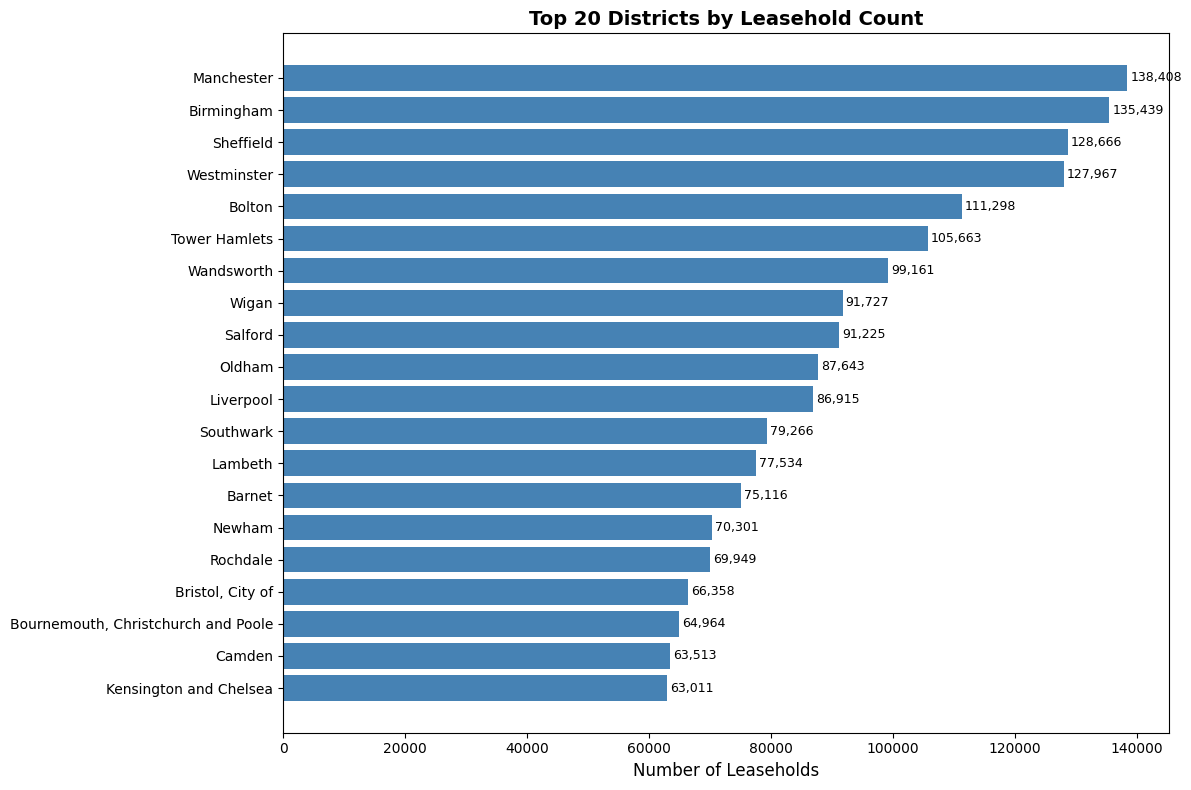

In [31]:
# Plot top 20 districts
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = df_results.head(20)
bars = ax.barh(top_20['district_name'], top_20['leasehold_count'], color='steelblue')

ax.set_xlabel('Number of Leaseholds', fontsize=12)
ax.set_title('Top 20 Districts by Leasehold Count', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest at top

# Add value labels
for bar, value in zip(bars, top_20['leasehold_count']):
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height()/2,
            f'{value:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

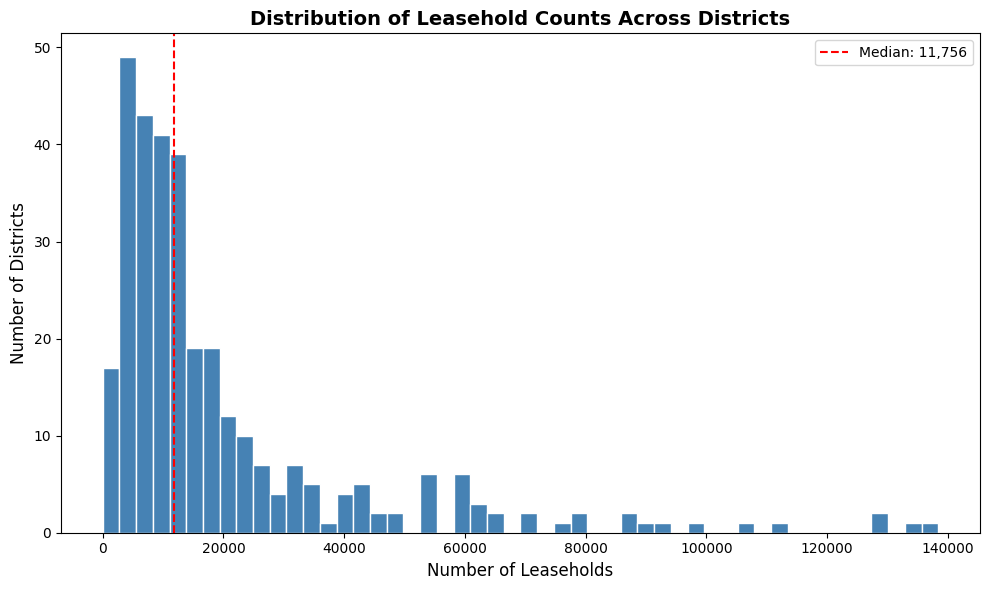

In [32]:
# Distribution histogram
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_results['leasehold_count'], bins=50, color='steelblue', edgecolor='white')
ax.set_xlabel('Number of Leaseholds', fontsize=12)
ax.set_ylabel('Number of Districts', fontsize=12)
ax.set_title('Distribution of Leasehold Counts Across Districts', fontsize=14, fontweight='bold')
ax.axvline(df_results['leasehold_count'].median(), color='red', linestyle='--', label=f'Median: {df_results["leasehold_count"].median():,.0f}')
ax.legend()

plt.tight_layout()
plt.show()

---
## 12. Export Results

Save the results to a CSV file for further analysis.

In [33]:
# Export to CSV
output_path = DATA_DIR / "district_leasehold_counts.csv"
df_results.to_csv(output_path, index=False)
print(f"✓ Results exported to: {output_path}")

✓ Results exported to: data/district_leasehold_counts.csv


---
## 13. Cleanup

Close the MongoDB connection.

In [34]:
# Close MongoDB connection
client.close()
print("✓ MongoDB connection closed.")

✓ MongoDB connection closed.
